# Twyne stETH-ETH Looping Economics Analysis

This notebook demonstrates the economics of leveraged stETH-ETH yield farming using the **Twyne credit delegation protocol**.

## What is Twyne?

Twyne enables **boosted leverage** beyond traditional DeFi limits. While Aave typically allows ~5x leverage for stETH-ETH looping, Twyne's credit delegation mechanism enables up to **50x leverage** by utilizing Credit LP (CLP) collateral.

## Contents

1. **Data Overview** - Historical stETH yield and ETH borrow rates
2. **Spread Analysis** - Understanding the yield spread opportunity
3. **Leverage Comparison** - Twyne vs traditional Aave looping
4. **Risk Transparency** - Health factor dynamics and liquidation risk
5. **Historical Backtest** - What would returns have looked like?

In [ ]:
# Setup
import warnings
warnings.filterwarnings('ignore', message='Unable to import Axes3D')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Import Twyne looping module
from twyne_looping import (
    # Data loading
    load_apr_data, compute_spreads, compute_rolling_stats,
    get_summary_stats, format_stats_report,
    # Economics
    psi, interest_rate, looped_yield, looped_yield_from_leverage,
    leverage_from_ltv, ltv_from_leverage, DEFAULTS,
    # Backtest
    run_backtest, run_multi_leverage_backtest, compare_backtests,
    plot_backtest_dashboard,
)
from twyne_looping.visualizations import (
    plot_historical_rates, plot_spread_distribution, plot_rolling_spread,
    plot_yield_vs_leverage, plot_leverage_comparison_timeseries,
    plot_twyne_advantage_histogram, plot_yield_heatmap, plot_days_to_liq_heatmap,
    plot_negative_spread_analysis, plot_summary_dashboard,
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

# Toggle for audience type
ADVANCED_MODE = False  # Set to True for DeFi-savvy audience (minimal annotations)

---
## 1. Data Overview

We have ~3 years of historical APR data from Aave and Lido.

In [2]:
# Load data
DATA_PATH = Path("stETH-ETH_historical_APR_data.csv")

df = load_apr_data(DATA_PATH)
df = compute_spreads(df)
df = compute_rolling_stats(df, windows=[7, 30, 90])

# Summary statistics
stats = get_summary_stats(df)
print(format_stats_report(stats))

Historical APR Data Summary
Date Range: 2023-01-27 to 2025-10-09
Total Days: 987

Staking + Lending Rate (r_stake):
  Mean:     3.88%
  Median:   3.54%
  Std:      1.05%
  Range:    2.82% to  13.22%

ETH Borrow Rate (r_borrow):
  Mean:     2.94%
  Median:   2.67%
  Std:      0.88%
  Range:    2.15% to  22.64%

Raw Spread (r_stake - r_borrow):
  Mean:     0.94%
  Median:   0.80%
  Std:      1.10%
  Range:  -18.87% to  10.53%
  Days Positive: 97.5%


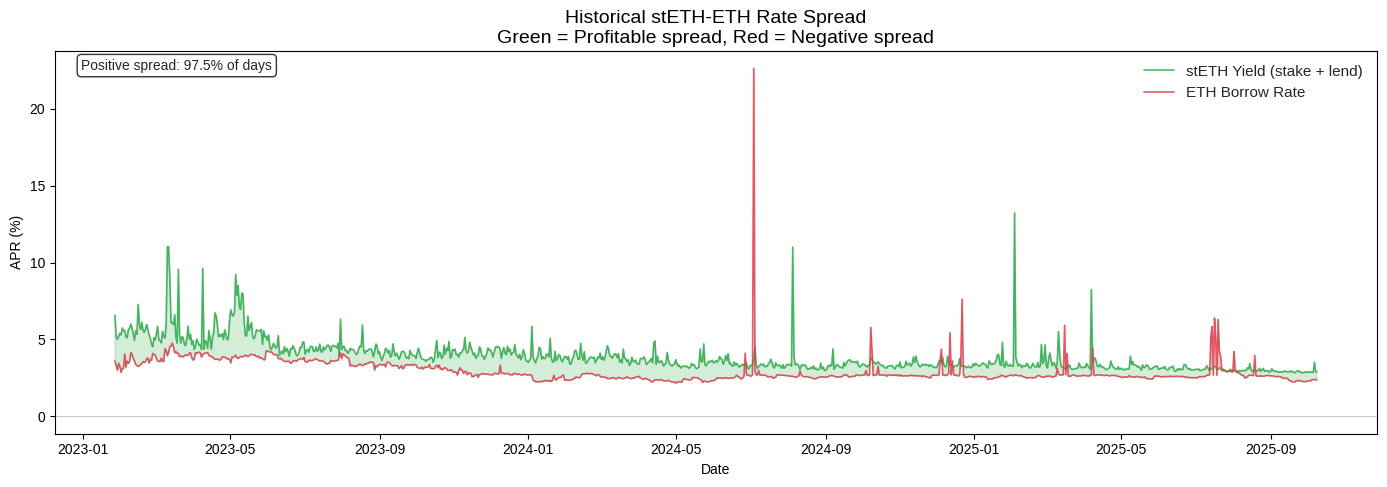

In [3]:
# Visualize historical rates
fig, ax = plt.subplots(figsize=(14, 5))
plot_historical_rates(df, ax=ax, advanced=ADVANCED_MODE)
plt.tight_layout()
plt.show()

---
## 2. Spread Analysis

### Raw Spread vs Net Rate

The **raw spread** = r_stake - r_borrow is only part of the picture.

For a Twyne looper, profitability is determined by the **net rate**:

$$r_{net} = r_{stake} - r_{borrow} - \Psi \cdot IR(u)$$

Where:
- **Ψ** = CLP cost factor (depends on boosted liquidation LTV)
- **IR(u)** = Twyne interest rate at utilization u

**Position dynamics:**
- **r_net > 0**: Position is profitable, Health Factor improves over time
- **r_net < 0**: Position loses value, Health Factor decays toward liquidation

The raw spread shown below is a useful proxy, but actual profitability depends on leverage (which affects Ψ) and the Twyne interest rate.

In [ ]:
# Spread distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_spread_distribution(df, ax=axes[0], advanced=ADVANCED_MODE)
plot_rolling_spread(df, ax=axes[1], advanced=ADVANCED_MODE)

plt.tight_layout()
plt.show()

# Key stats - raw spread
print(f"\nRaw Spread Statistics (r_stake - r_borrow):")
print(f"  Mean spread: {df['spread_raw'].mean()*100:.2f}%")
print(f"  Days with positive spread: {(df['spread_raw'] > 0).mean()*100:.1f}%")

# Show impact of credit delegation cost
from twyne_looping import psi, interest_rate, net_rate, ltv_from_leverage, DEFAULTS

# Example at 20x leverage
L = 20
liq_ltv_t = ltv_from_leverage(L) * 1.05  # assuming HF=1.05
psi_val = psi(liq_ltv_t)
ir_u = interest_rate(DEFAULTS['utilization'])
credit_cost = psi_val * ir_u

print(f"\nCredit Delegation Cost (at {L}x leverage, 95% utilization):")
print(f"  Ψ (CLP cost factor): {psi_val:.3f}")
print(f"  IR(u): {ir_u*100:.2f}%")
print(f"  Credit cost (Ψ·IR): {credit_cost*100:.2f}%")
print(f"\nNet rate = raw spread - {credit_cost*100:.2f}%")
print(f"  → A raw spread of {credit_cost*100:.2f}% is needed just to break even at {L}x")

---
## 3. Leverage Comparison: Twyne vs Traditional Aave

### The Twyne Advantage

| Platform | Max LTV | Max Leverage | stETH-ETH Looping |
|----------|---------|--------------|-------------------|
| Traditional Aave | ~80% | ~5x | Limited yield amplification |
| **Twyne** | up to 98% | up to 50x | Significant yield boost |

Higher leverage amplifies the spread:
- At 5x: A 1% spread → ~5% net yield
- At 20x: A 1% spread → ~20% net yield (minus Twyne fees)

Current Rates (as of 2025-10-09):
  stETH Yield: 2.89%
  ETH Borrow:  2.36%
  Spread:      0.53%


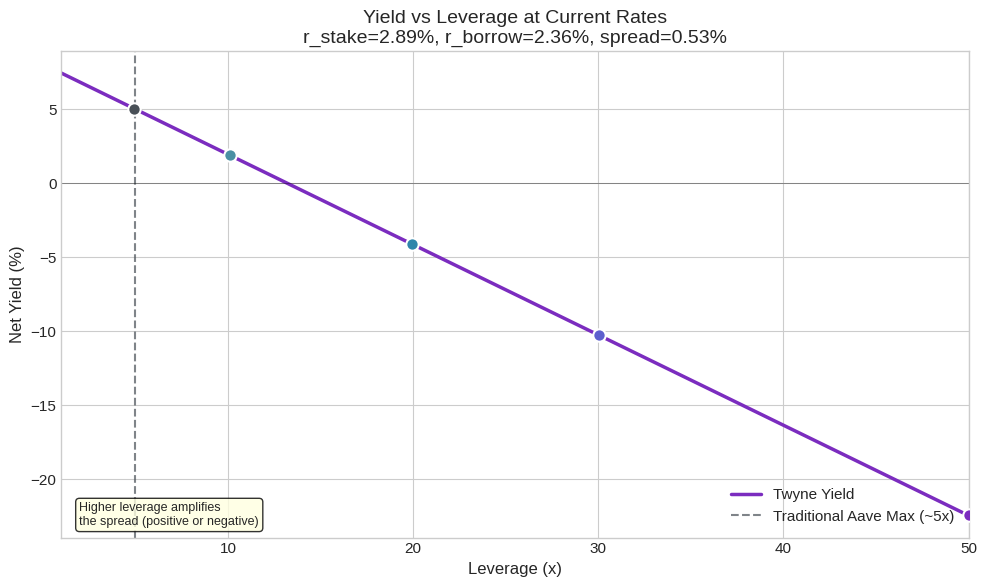

In [5]:
# Use current (latest) rates for point-in-time analysis
r_stake_current = df['r_stake'].iloc[-1]
r_borrow_current = df['r_borrow'].iloc[-1]

print(f"Current Rates (as of {df.index[-1].strftime('%Y-%m-%d')}):")
print(f"  stETH Yield: {r_stake_current*100:.2f}%")
print(f"  ETH Borrow:  {r_borrow_current*100:.2f}%")
print(f"  Spread:      {(r_stake_current - r_borrow_current)*100:.2f}%")

# Yield vs Leverage curve
fig, ax = plt.subplots(figsize=(10, 6))
plot_yield_vs_leverage(r_stake_current, r_borrow_current, ax=ax, advanced=ADVANCED_MODE)
plt.tight_layout()
plt.show()

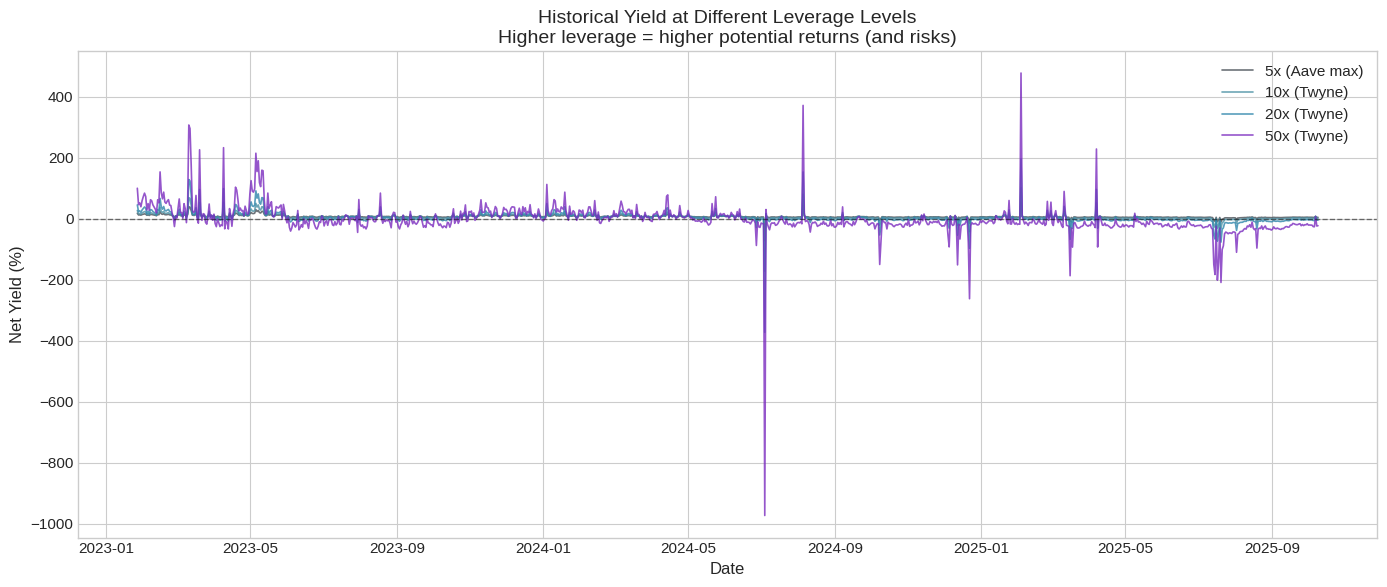

In [6]:
# Historical yield comparison at different leverage levels
fig, ax = plt.subplots(figsize=(14, 6))
plot_leverage_comparison_timeseries(df, leverage_levels=[5, 10, 20, 50], ax=ax, advanced=ADVANCED_MODE)
plt.tight_layout()
plt.show()

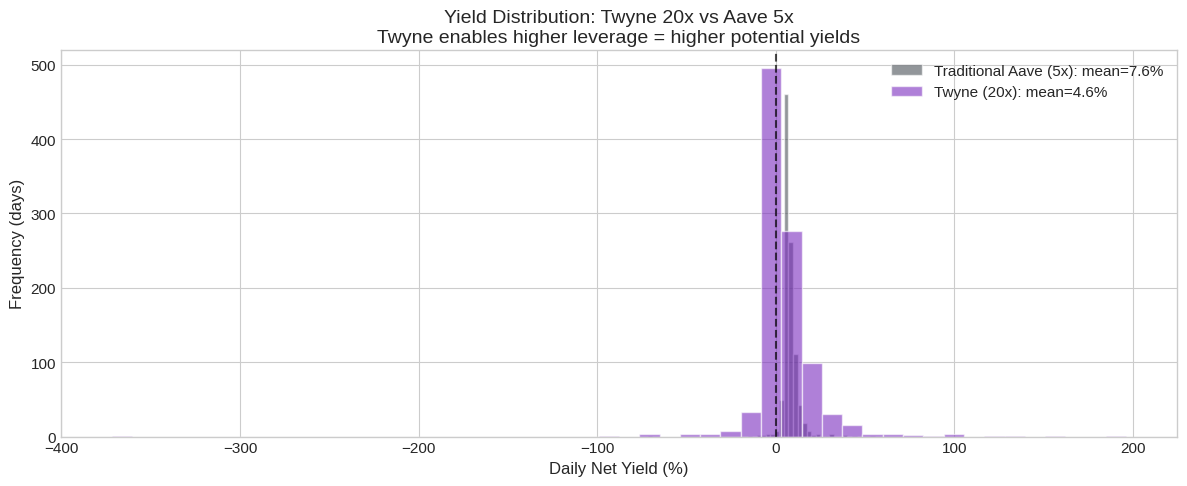

In [7]:
# Distribution comparison: Twyne 20x vs Aave 5x
fig, ax = plt.subplots(figsize=(12, 5))
plot_twyne_advantage_histogram(df, twyne_leverage=20, aave_leverage=5, ax=ax, advanced=ADVANCED_MODE)
plt.tight_layout()
plt.show()

---
## 4. Risk Transparency

### Health Factor Dynamics

The **Health Factor (HF)** measures how close a position is to liquidation:
- HF > 1: Position is solvent
- HF = 1: Liquidation threshold
- HF < 1: Liquidated

When the spread is negative, HF decays over time. Higher leverage = faster decay.

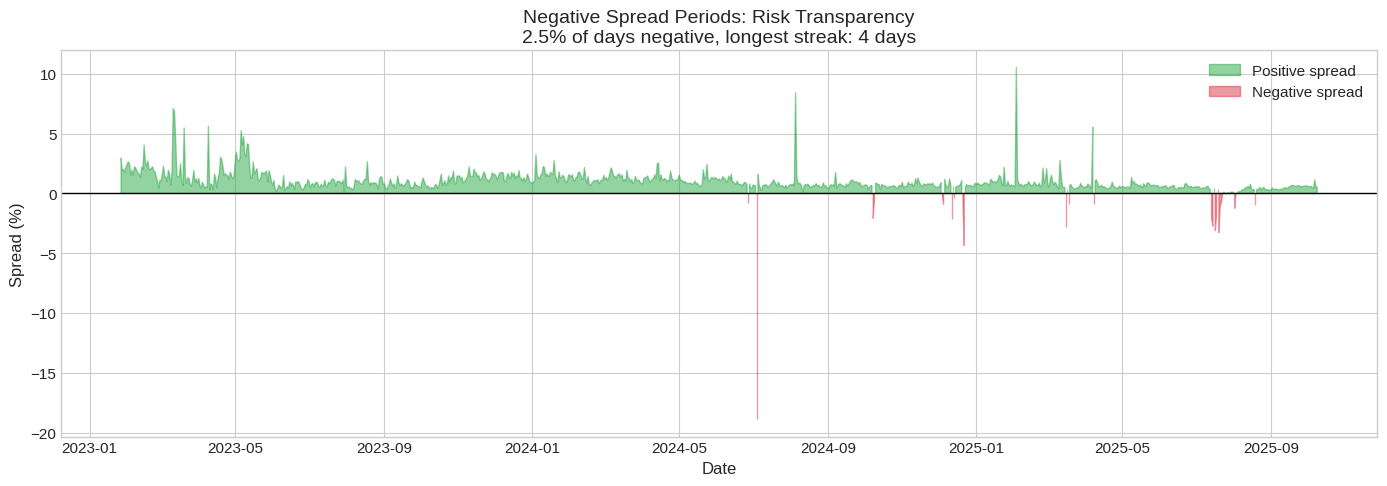

In [8]:
# Negative spread analysis
fig, ax = plt.subplots(figsize=(14, 5))
plot_negative_spread_analysis(df, ax=ax, advanced=ADVANCED_MODE)
plt.tight_layout()
plt.show()

Average Historical Rates:
  stETH Yield: 3.88%
  ETH Borrow:  2.94%
  Spread:      0.94%


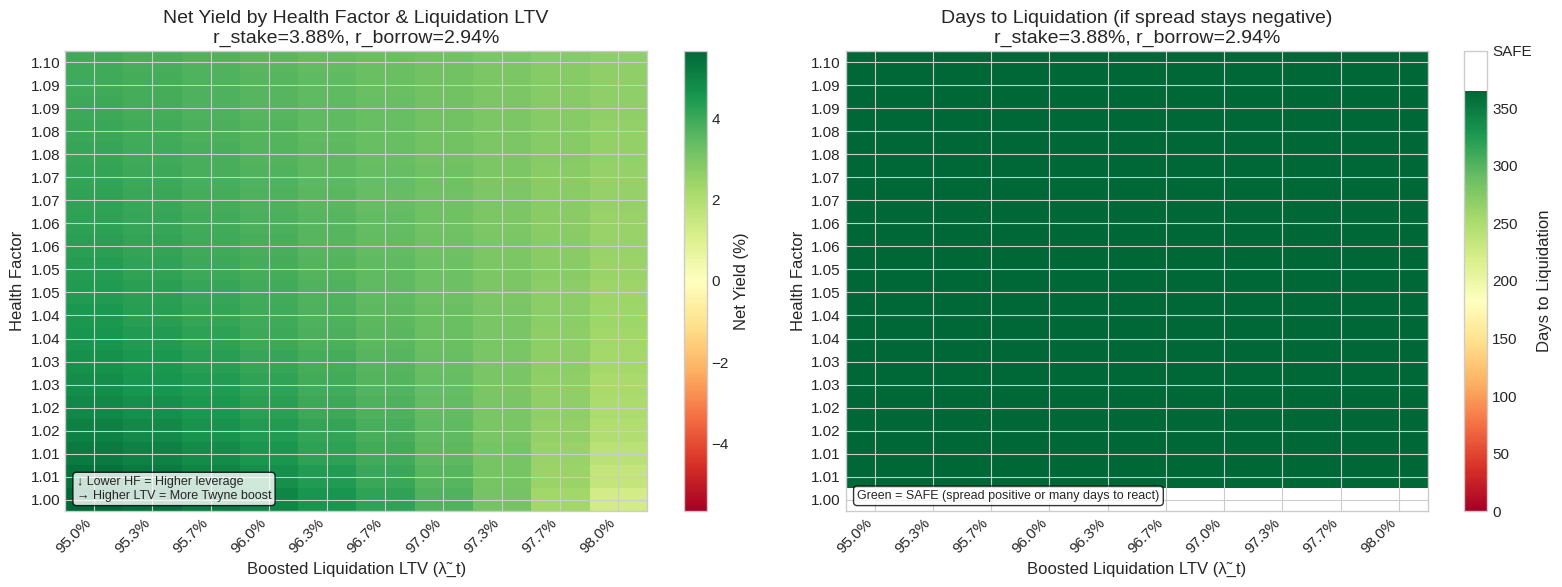

In [9]:
# Yield and Days-to-Liquidation Heatmaps
# Use average historical rates for this analysis
r_stake_avg = df['r_stake'].mean()
r_borrow_avg = df['r_borrow'].mean()

print(f"Average Historical Rates:")
print(f"  stETH Yield: {r_stake_avg*100:.2f}%")
print(f"  ETH Borrow:  {r_borrow_avg*100:.2f}%")
print(f"  Spread:      {(r_stake_avg - r_borrow_avg)*100:.2f}%")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

plot_yield_heatmap(r_stake_avg, r_borrow_avg, ax=axes[0], advanced=ADVANCED_MODE)
plot_days_to_liq_heatmap(r_stake_avg, r_borrow_avg, ax=axes[1], advanced=ADVANCED_MODE)

plt.tight_layout()
plt.show()

---
## 5. Historical Backtest

What would returns have looked like if you had entered a leveraged position at the start of our data?

In [10]:
# Run backtests at multiple leverage levels
leverage_levels = [5, 10, 20, 30, 50]
results = run_multi_leverage_backtest(df, leverage_levels=leverage_levels, initial_hf=1.05)

# Summary table
comparison = compare_backtests(results)
print("\nBacktest Comparison:")
print(comparison.to_string())


Backtest Comparison:
          total_return  annualized_return  sharpe_ratio  max_drawdown    min_hf  n_days  was_liquidated
leverage                                                                                               
5            19.471938           6.800556     25.365731      0.184670  1.050000     987           False
10           13.093319           4.655338      8.541733      0.808456  1.050000     987           False
20            0.545281           0.201304      0.187337      9.553613  1.046269     987           False
30          -11.948527          -4.596745     -2.727779     20.130721  1.043562     987           False
50          -36.846108         -15.630307     -5.414520     44.074528  1.041400     987           False


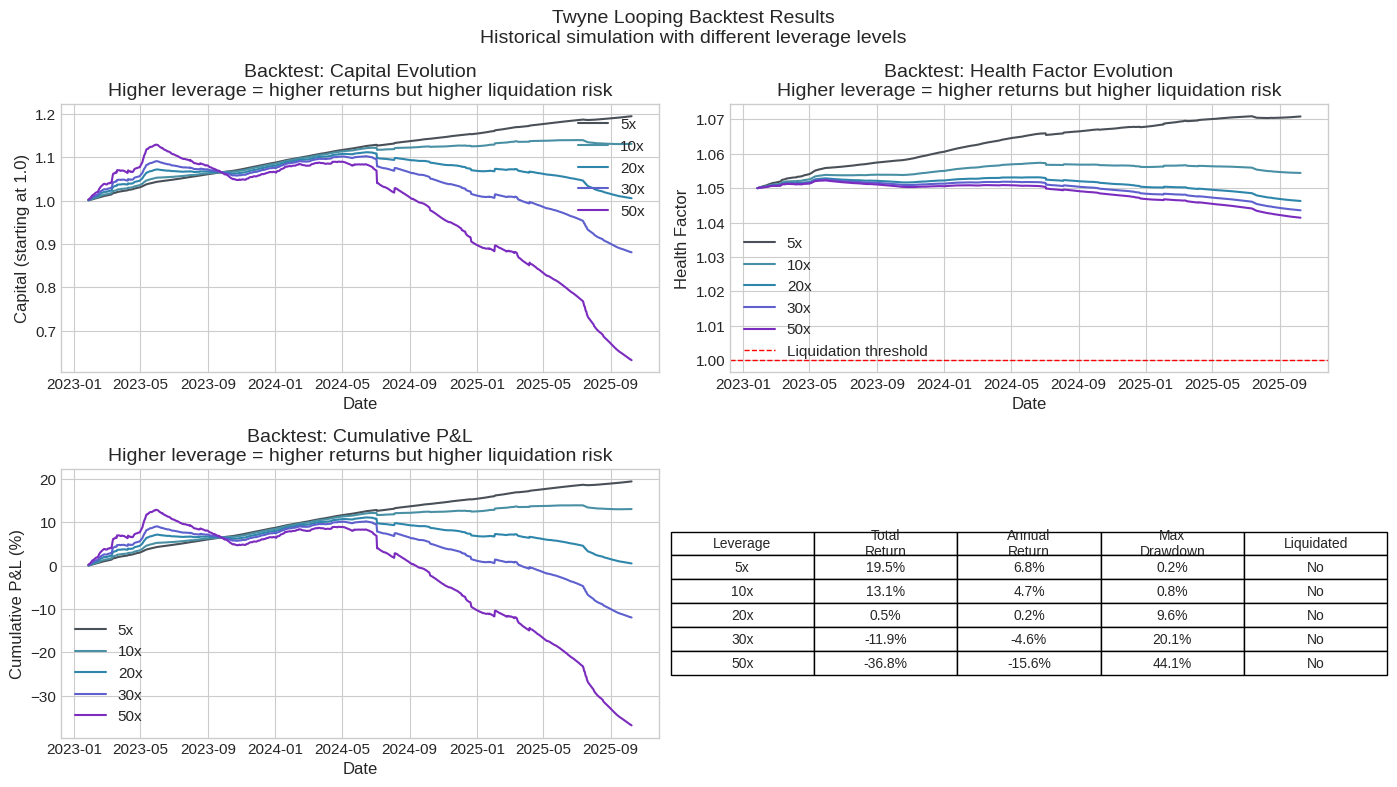

In [11]:
# Detailed backtest dashboard
fig = plot_backtest_dashboard(results, advanced=ADVANCED_MODE)
plt.show()

In [12]:
# Individual backtest details
for L in [5, 20]:
    print(results[L].summary())
    print()

Backtest Results (Leverage: 5x, Initial HF: 1.05)
Duration: 987 days
Total Return: 19.47%
Annualized Return: 6.80%
Sharpe Ratio: 25.37
Max Drawdown: 0.18%
Min Health Factor: 1.050
Position remained solvent

Backtest Results (Leverage: 20x, Initial HF: 1.05)
Duration: 987 days
Total Return: 0.55%
Annualized Return: 0.20%
Sharpe Ratio: 0.19
Max Drawdown: 9.55%
Min Health Factor: 1.046
Position remained solvent



---
## Summary Dashboard

A comprehensive view of the Twyne stETH-ETH looping opportunity.

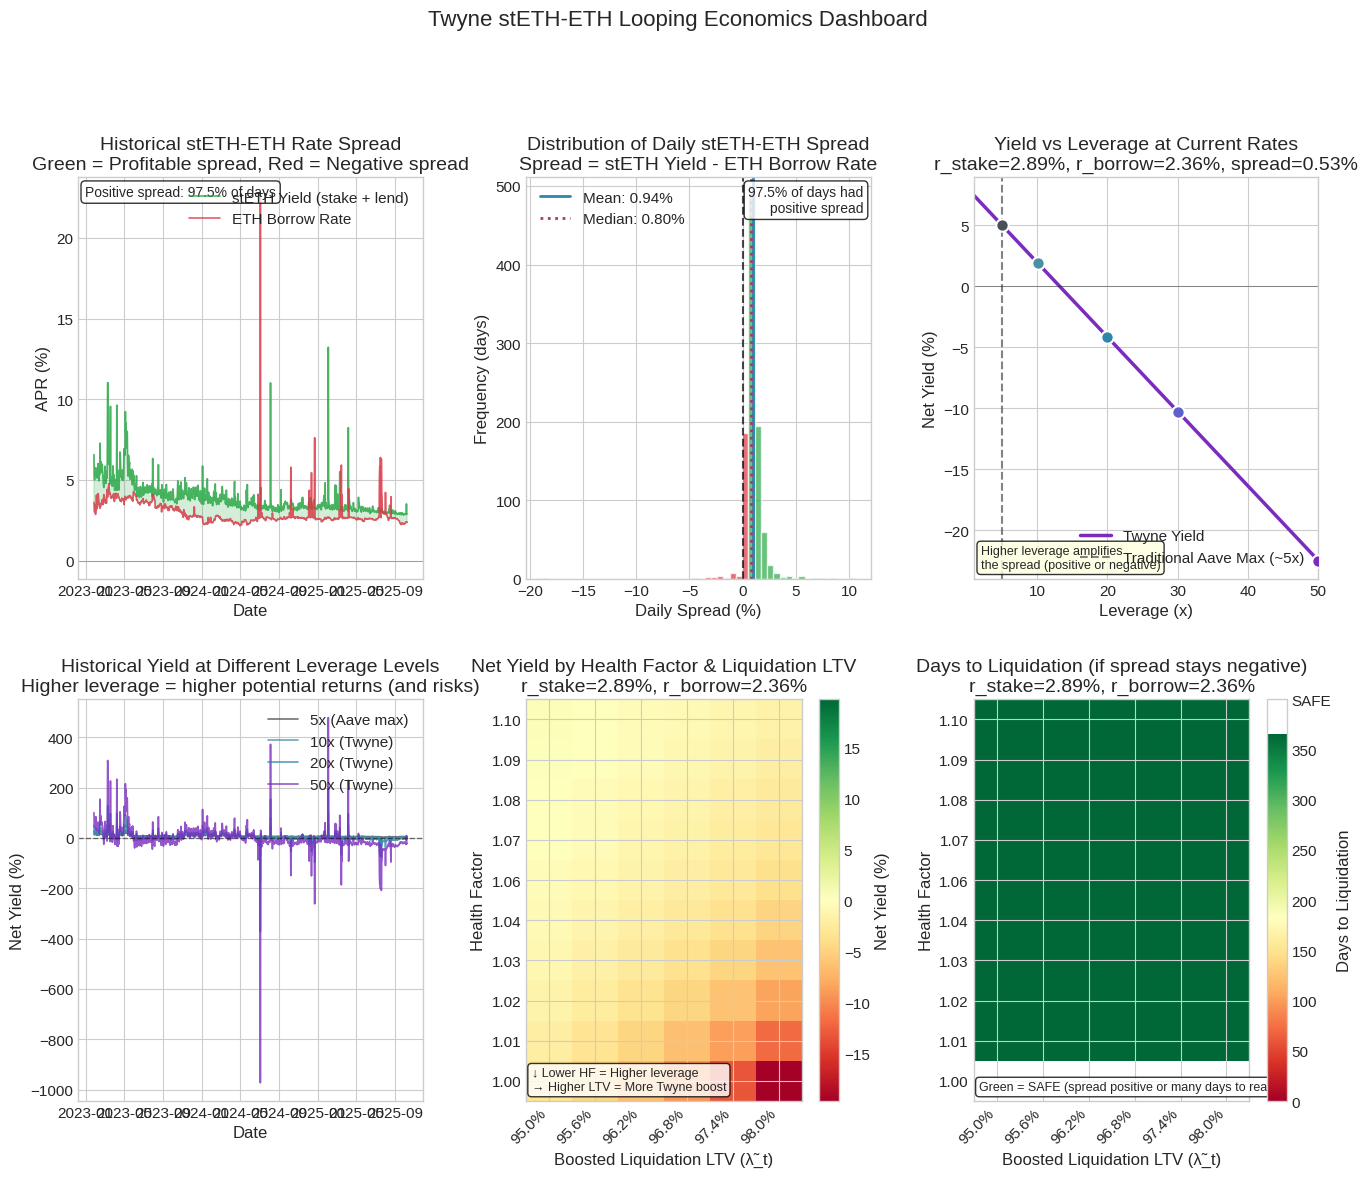

In [13]:
# Generate full summary dashboard
fig = plot_summary_dashboard(
    df,
    r_stake=r_stake_current,
    r_borrow=r_borrow_current,
    advanced=ADVANCED_MODE,
    figsize=(16, 12),
    save_path="figures/summary_dashboard.png"  # Uncomment to save
)
plt.show()

---
## Interactive Parameter Exploration

Adjust parameters below to explore different scenarios.

In [14]:
# Interactive exploration (adjust these parameters)
CUSTOM_R_STAKE = 0.035   # 3.5% stETH yield
CUSTOM_R_BORROW = 0.025  # 2.5% ETH borrow
CUSTOM_LEVERAGE = 20     # 20x leverage
CUSTOM_HF = 1.05         # Starting health factor

# Compute yield
from twyne_looping.economics import looped_yield_from_leverage, psi, interest_rate, DEFAULTS

ir_u = interest_rate(DEFAULTS['utilization'])
liq_ltv_t = ltv_from_leverage(CUSTOM_LEVERAGE) * CUSTOM_HF
psi_val = psi(liq_ltv_t)

custom_yield = looped_yield_from_leverage(
    CUSTOM_R_STAKE, CUSTOM_R_BORROW, CUSTOM_LEVERAGE, ir_u, psi_val
)

print(f"\nCustom Scenario Analysis:")
print(f"  stETH Yield:      {CUSTOM_R_STAKE*100:.2f}%")
print(f"  ETH Borrow Rate:  {CUSTOM_R_BORROW*100:.2f}%")
print(f"  Raw Spread:       {(CUSTOM_R_STAKE - CUSTOM_R_BORROW)*100:.2f}%")
print(f"  Leverage:         {CUSTOM_LEVERAGE}x")
print(f"  Health Factor:    {CUSTOM_HF:.2f}")
print(f"  ---")
print(f"  Net Yield:        {custom_yield*100:.2f}%")
print(f"  CLP Cost Factor:  {psi_val:.3f}")


Custom Scenario Analysis:
  stETH Yield:      3.50%
  ETH Borrow Rate:  2.50%
  Raw Spread:       1.00%
  Leverage:         20x
  Health Factor:    1.05
  ---
  Net Yield:        1.10%
  CLP Cost Factor:  0.235


---
## Key Takeaways

1. **Historical spread has been predominantly positive** - stETH-ETH looping has been a profitable strategy

2. **Twyne enables significantly higher yields** - By allowing up to 50x leverage vs Aave's ~5x

3. **Higher leverage = higher risk** - Health factor decays faster during negative spread periods

4. **The trade-off is clear** - Users choose their risk/reward profile by selecting leverage level

---

*This analysis is for educational purposes. Past performance does not guarantee future results. Always understand the risks before participating in DeFi.*